## 对手写数字数据集(缩小版)进行分类预测

**这一篇主要是针对小型的mnist数据集进行分类预测，总共有1797个样本，每个样本有64个特征(8 x 8的灰度图像)。**

In [1]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

### 一、导入数据

In [2]:
digits = load_digits()
X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


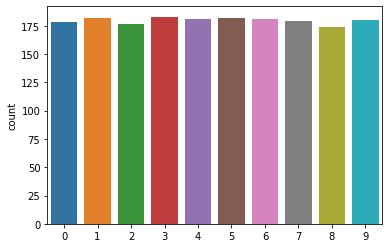

In [3]:
sns.countplot(y)

**上图展示了数字0到9的分布，互相之间差别不大**

**划分训练集、测试集，1/3的数据用于测试**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 二、模型训练

**首先对数据集进行规范化，加快模型收敛**

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

**从训练集中划分验证集，采用5折交叉验证**

In [6]:
cv_splits = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

**为每个分类器调参，找出最好的分类器**

In [7]:
clf_names = [
    "KNN",
    "SVM",
    "DecisionTree",
    "NaiveBayes"
]  # 用于比较的分类器名称集合
clf_list = [
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    MultinomialNB()
]  # 用于比较的分类器
clf_param_grids = [
    {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree"]},  # KNN的调参列表
    {"C": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
    "kernel": ["linear", "poly", "rbf"], "degree": [2, 3, 4], 
     "gamma": ["scale", "auto"]},  # SVM的调参列表
    {"criterion": ["gini", "entropy"], "splitter": ["best", "random"],
    "max_depth": [3, 5, 7, 9], "max_features": ["sqrt", "log2"]},  # DecisionTree的调参列表
    {"alpha": [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]}  # NaiveBayes的调参列表
]

In [8]:
clf_compare = pd.DataFrame(columns=["Name", "Mean train score", 
                                    "Mean test score", 
                                    "3 * Std test score",
                                    "Best params",
                                    "Mean fit time"])
row_index = 0
for clf_name, clf, clf_param_grid in zip(clf_names, clf_list, clf_param_grids):
    clf_compare.loc[row_index, "Name"] = clf_name
    gridsearch_cv = GridSearchCV(clf, clf_param_grid, n_jobs=-1, cv=cv_splits,
                                return_train_score=True)
    gridsearch_cv.fit(X_train, y_train)
    cv_results = gridsearch_cv.cv_results_
    clf_compare.loc[row_index, "Mean train score"] = np.mean(cv_results["mean_train_score"])
    clf_compare.loc[row_index, "Mean test score"] = np.mean(cv_results["mean_test_score"])
    clf_compare.loc[row_index, "3 * Std test score"] = 3*np.std(cv_results["mean_test_score"])
    clf_compare.loc[row_index, "Best params"] = str(gridsearch_cv.best_params_)
    clf_compare.loc[row_index, "Mean fit time"] = np.mean(cv_results["mean_fit_time"])
    row_index += 1

In [9]:
clf_compare

,Name,Mean train score,Mean test score,3 * Std test score,Best params,Mean fit time
0,KNN,0.992555,0.978631,0.00952099,"{'algorithm': 'ball_tree', 'n_neighbors': 3, '...",0.00770258
1,SVM,0.703986,0.686238,1.15141,"{'C': 10, 'degree': 2, 'gamma': 'scale', 'kern...",0.662077
2,DecisionTree,0.704304,0.61499,0.39048,"{'criterion': 'entropy', 'max_depth': 9, 'max_...",0.00305079
3,NaiveBayes,0.91207,0.902397,0.00625931,{'alpha': 3},0.00533021


**上表看出，表现最好的是KNN算法**

### 三、测试模型

In [10]:
clf_compare.loc[0, "Best params"]

"{'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}"

In [11]:
knn_clf = KNeighborsClassifier(algorithm="ball_tree", n_neighbors=3, weights="distance")
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print("预测准确率为%.4f" % accuracy_score(y_test, y_pred))

预测准确率为0.9899


**KNN的预测准确率高达98.99%，表现还是很不错的。**

### 四、利用CNN来进行预测

In [12]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.utils import np_utils

Using TensorFlow backend.


In [13]:
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**对数据进行reshape以符合CNN的输入条件**

In [14]:
X_train = X_train.reshape(-1, 8, 8, 1) / 255  # 标准化
X_test = X_test.reshape(-1, 8, 8, 1) / 255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

**构建并训练CNN**

In [15]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", input_shape=(8, 8, 1)))  # 第一层一定要添加输入shape,输出8*8*32
model.add(Activation("relu"))  # 激活
model.add(MaxPool2D(pool_size=(2,2)))  # 池化层，输出4*4*32
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="same"))  # 输出4*4*64
model.add(Activation("relu"))  # 激活
model.add(MaxPool2D(pool_size=(2, 2)))  # 池化层，输出2*2*64
model.add(Flatten())  # 变成[n_samples, 2*2*64]
model.add(Dense(1024))  # 全连接层，输出到1024个神经元
model.add(Activation("relu"))  # 激活
model.add(Dense(10))  # 输出到10个神经元
model.add(Activation("softmax"))  # softmax激活
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
1203/1203 [==============================] - 2s 1ms/step - loss: 2.2648 - accuracy: 0.2868: 0s - loss: 2.2846 - accuracy
Epoch 2/20
1203/1203 [==============================] - 1s 577us/step - loss: 1.5737 - accuracy: 0.5337
Epoch 3/20
1203/1203 [==============================] - 1s 587us/step - loss: 0.7376 - accuracy: 0.7747
Epoch 4/20
1203/1203 [==============================] - 1s 668us/step - loss: 0.5013 - accuracy: 0.8487
Epoch 5/20
1203/1203 [==============================] - 1s 684us/step - loss: 0.3616 - accuracy: 0.89030s - loss: 0.4
Epoch 6/20
1203/1203 [==============================] - 1s 605us/step - loss: 0.2794 - accuracy: 0.91600s - loss: 0.2871 - accuracy: 0.
Epoch 7/20
1203/1203 [==============================] - 1s 599us/step - loss: 0.2401 - accuracy: 0.93430s - loss: 0.2880 - 
Epoch 8/20
1203/1203 [==============================] - 1s 704us/step - loss: 0.2069 - accuracy: 0.9360
Epoch 9/20
1203/1203 [==============================] - 1s 532us/step - lo

In [16]:
model.evaluate(X_test, y_test)

594/594 [==============================] - 0s 449us/step


[0.12781845690425397, 0.9579124450683594]

### 四、总结

**这里我们使用了KNN，SVM，决策树，朴素贝叶斯算法对手写数字数据集进行了分类预测，最终使用KNN的预测准确率高达98.99%。此外，使用了CNN，但是面对数据量较小的情况下，CNN的预测准确率为95.79%，其表现不及KNN。**